# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



## 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [1]:
import json
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# выгружаем первые 200 записей
df = pd.read_json("data/train.jsonl", lines=True, nrows=200)

In [3]:
df.head()

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...


In [4]:
entity_counter = Counter()

for entities in df['entities']:
    entity_counter.update(e.split()[1] for e in entities)

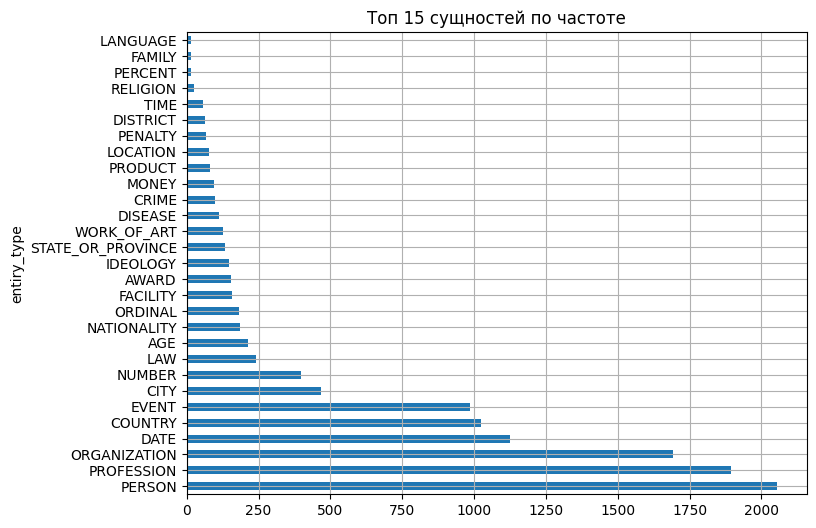

In [5]:
pd.DataFrame(
    entity_counter.most_common(30),
    columns=["entiry_type", "cnt"]
).plot.barh(
    x="entiry_type",
    y="cnt",
    figsize=(8, 6),
    legend=False,
    grid=True,
    title='Топ 15 сущностей по частоте'
);

In [6]:
relation_counter = Counter()

for relations in df['relations']:
    relation_counter.update(
        r.split("\t")[1].split()[0] for r in relations
    )

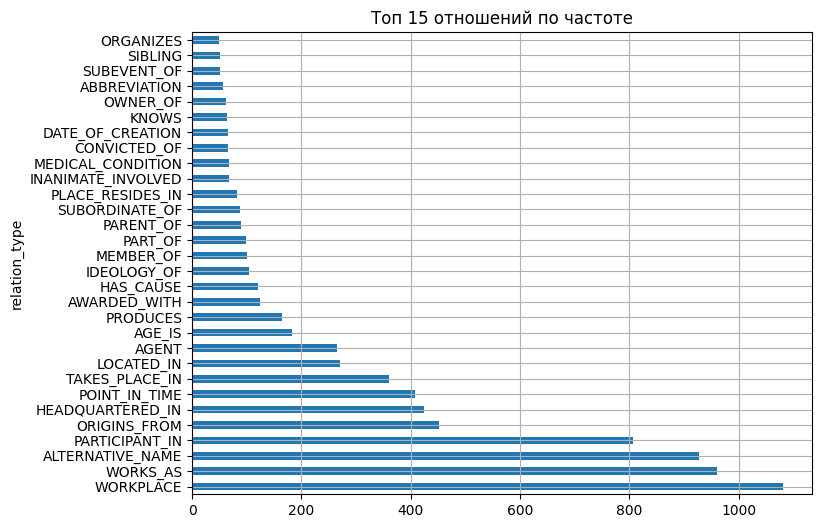

In [7]:
pd.DataFrame(
    relation_counter.most_common(30),
    columns=["relation_type", "cnt"]
).plot.barh(
    x="relation_type",
    y="cnt",
    figsize=(8, 6),
    legend=False,
    grid=True,
    title='Топ 15 отношений по частоте'
);

In [8]:
df['text_len'] = df['text'].map(len)

Минимальная длина текста: 537
Медианная длина текста: 1484
95% текстов имеют длину в интервале [537, 2872]
Тексты большей длины можно рассматривать как выбросы.


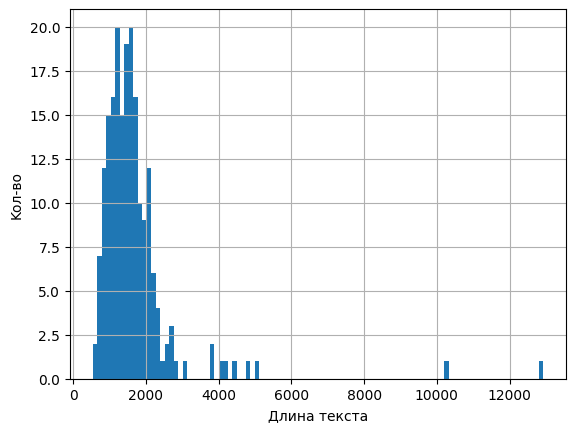

In [9]:
low, high = df['text_len'].quantile([0.0, 0.95])
median = df['text_len'].median()

print(f"Минимальная длина текста: {low:.0f}")
print(f"Медианная длина текста: {median:.0f}")

print(f"95% текстов имеют длину в интервале [{low:.0f}, {high:.0f}]")
print("Тексты большей длины можно рассматривать как выбросы.")


df['text_len'].hist(bins=100)
plt.xlabel("Длина текста")
plt.ylabel("Kол-во");

In [10]:
# кол-во сущностей 
df['cnt_entities'] = df['entities'].map(len)

Минимальное кол-во сущностей: 11
Медианное кол-во сущноестей: 53
95% текстов имеют кол-во сущностей в интервале [11, 113]


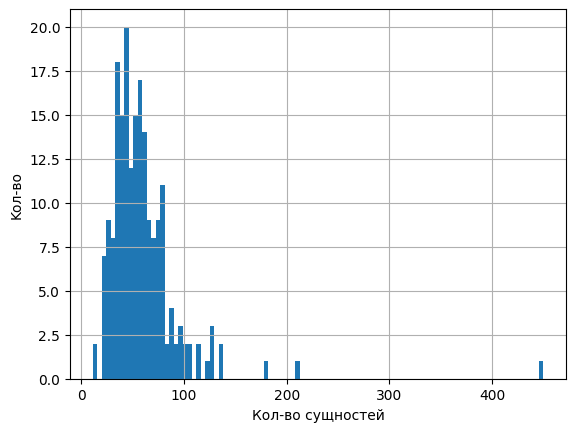

In [11]:
low, high = df['cnt_entities'].quantile([0.0, 0.95])
median = df['cnt_entities'].median()

print(f"Минимальное кол-во сущностей: {low:.0f}")
print(f"Медианное кол-во сущноестей: {median:.0f}")

print(f"95% текстов имеют кол-во сущностей в интервале [{low:.0f}, {high:.0f}]")

df['cnt_entities'].hist(bins=100)
plt.xlabel("Кол-во сущностей")
plt.ylabel("Kол-во");

## Выводы

- Наблюдается сильный дисбаланс по типам сущностей и отношений. Это может привести к тому, что модель будет лучше распознавать частые классы и хуже редкие.
- Большинство документов короче 3000 символов, однако есть и сильные выбросы длиной более 10000. При обучении моделей с ограниченным контекстным окном такие тексты могут требовать усечения или разбиения на части, что потенциально приводит к потере части разметки.
- Число сущностей в большинстве документов менее 110. Но встречаются документы и выбросы на 400+ сущностей. Тексты с высокой плотностью сущностей могут представлять повышенную сложность для модели, так как требуют точного распознавания большого количества сущностей в одном контексте.


## Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [12]:

import re
from collections import Counter

# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [13]:
def get_records(str_path):
    path = Path(str_path)  
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records

def parse_entity_and_relations(records):
    for r in records:
        r['entities'] = [parse_entity_line(e) for e in r.get('entities', [])]
        r['relations'] = [parse_relation_line(e) for e in r.get('relations', [])]
    return records



In [14]:
def make_event_list(records, K=None):
    def _get_types(field):
        counter = Counter()
        for r in records:
            for item in r.get(field, []):
                counter[item['type']] += 1

        if K is None:
            return list(counter.keys())
        else:
            return [key for key, _ in counter.most_common(K)]

    return _get_types('relations'), _get_types('entities')

In [15]:
train_records = get_records("data/train.jsonl")
test_records = get_records("data/test.jsonl")

print("Кол-во записий в train:", len(train_records))
print("Кол-во записий в test:", len(test_records))

Кол-во записий в train: 746
Кол-во записий в test: 93


In [16]:
train_records = parse_entity_and_relations(train_records)
test_records = parse_entity_and_relations(test_records)

In [17]:
relations, entities =  make_event_list(train_records)

In [18]:
print(relations[:5])
print(entities[:5])

['TAKES_PLACE_IN', 'AGE_IS', 'HEADQUARTERED_IN', 'ORGANIZES', 'LOCATED_IN']
['NATIONALITY', 'CITY', 'DATE', 'COUNTRY', 'ORGANIZATION']


In [19]:
from typing import List

def build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]:
    event2idx = {e: i for i, e in enumerate(event_list)}
    examples = []

    for r in records:
        text = r['text']
        tokens = r['text'].split()

        # token_spans
        token_spans = []
        start_from = 0
        for t in tokens:
            span_start = text.find(t, start_from)
            span_end = span_start + len(t)
            token_spans.append((span_start, span_end))
            start_from = span_end
        
        # BIO
        token_labels = ["O"] * len(tokens)

        for ent in r.get("entities", []):
            init_type = ent["type"]
            span_start = ent["start"]
            span_stop = ent["end"]

            pos_ids = []
            for i, (ts0, ts1) in enumerate(token_spans):
                if ts0 < span_stop and ts1 > span_start:
                    pos_ids.append(i)

            if len(pos_ids) == 0:
                continue

            free_ids = [tid for tid in pos_ids if token_labels[tid] == "O"]
            if len(free_ids) == 0:
                continue
            
            token_labels[free_ids[0]] = "B-" + init_type
            for tid in free_ids[1:]:
                token_labels[tid] = "I-" + init_type

        # cls_vec 
        cls_vec = [0] * len(event_list)
        for rel in r.get("relations", []):
            rel_type = rel["type"]
            idx = event2idx.get(rel_type)
            if idx is not None:
                cls_vec[idx] = 1

        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec,
        })

    return examples

In [20]:
train_examples = build_examples_from_nerel(train_records, event_list=relations)
test_examples = build_examples_from_nerel(test_records, event_list=relations)

In [21]:
print('Проверка разметки')
top_n = 20
i = 0

for tok, tag in zip(train_examples[i]['tokens'][:top_n], train_examples[i]['tags'][:top_n]):
    print(f"{tok:<20} {tag}")

Проверка разметки
Пулеметы,            O
автоматы             O
и                    O
снайперские          O
винтовки             O
изъяты               O
в                    O
арендуемом           O
американцами         B-NATIONALITY
доме                 O
в                    O
Бишкеке              B-CITY
05/08/2008           B-DATE
10:35                B-TIME
БИШКЕК,              B-CITY
5                    B-DATE
августа              I-DATE
/Новости-Грузия/.    B-COUNTRY
Правоохранительные   B-ORGANIZATION
органы               I-ORGANIZATION


## 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [22]:
from transformers import AutoTokenizer

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

/home/ubuntu/yandex_practicum_nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
unique_labels = set()
for ex in train_examples:
    unique_labels.update(ex["tags"])
unique_labels.add("O")

label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

In [24]:
def tokenize_and_align_labels(examples_batch):
    tokenized = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=123,
        return_offsets_mapping=True,   
    )

    labels = []
    for i, word_labels in enumerate(examples_batch["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)

        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif prev_word_idx != word_idx:
                label_ids.append(label2id[word_labels[word_idx]])
            else:
                label_ids.append(-100)
            prev_word_idx = word_idx

        labels.append(label_ids)

    tokenized["labels"] = labels
    tokenized["cls_labels"] = examples_batch["cls_vec"]
    return tokenized


In [25]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_list(train_examples),
    "test": Dataset.from_list(test_examples),
})

In [26]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "tokens", "token_spans", "tags", "cls_vec"]
)

Map: 100%|██████████| 93/93 [00:00<00:00, 639.37 examples/s]


In [27]:
print(tokenized_dataset)
print(tokenized_dataset["train"][0].keys())
print(tokenized_dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'],
        num_rows: 746
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'],
        num_rows: 93
    })
})
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'])
{'input_ids': [101, 524, 63602, 50362, 10292, 117, 541, 94454, 27159, 12202, 549, 558, 19147, 29633, 14354, 88504, 41335, 10648, 10387, 89982, 12202, 543, 40585, 92154, 10227, 12579, 10364, 541, 33930, 15238, 23716, 10508, 44838, 543, 42578, 10205, 10831, 120, 11052, 120, 10203, 10150, 131, 10803, 510, 27735, 40051, 14736, 45224, 14736, 117, 126, 14165, 120, 78718, 12189, 118, 512, 14360, 22685, 120, 119, 524, 86310, 51823, 32229, 42528, 79987, 519, 23312, 14122, 28791, 13248, 37235, 10227, 50080, 543, 44838, 117, 40585, 92154, 10227, 12579, 10364, 77879

In [28]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import torch


data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True
)

def collactor_with_cls(batch):

    cls_labels = torch.tensor(
        [x["cls_labels"] for x in batch],
        dtype=torch.float
    )

    for x in batch:
        x.pop("cls_labels")

    batch = data_collator(batch)
    batch["cls_labels"] = cls_labels
    return batch

In [29]:
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

In [30]:
batch = next(iter(train_dataloader))

print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:   ", batch["labels"].shape)
print("cls_labels in batch:" , "cls_labels" in batch)

input_ids shape: torch.Size([16, 123])
labels shape:    torch.Size([16, 123])
cls_labels in batch: True


In [31]:
labels = batch["labels"]
labels

tensor([[-100,   22, -100,  ...,   56, -100, -100],
        [-100,    8,   56,  ..., -100, -100, -100],
        [-100,   56,   56,  ...,   50, -100, -100],
        ...,
        [-100,   22, -100,  ...,   56, -100, -100],
        [-100,   26, -100,  ..., -100, -100, -100],
        [-100,   56,   56,  ...,   34,   56, -100]])

In [32]:
top_n = 30
i = 0

input_ids = batch["input_ids"][i]
labels_i = batch["labels"][i]

tokens = tokenizer.convert_ids_to_tokens(input_ids)

for tok, lab in zip(tokens[:top_n], labels_i[:top_n]):
    print(f"{tok:<15} {lab}")

[CLS]           -100
М               22
##ел            -100
Г               50
##иб            -100
##сон           -100
и               56
О               22
##кса           -100
##на            -100
Г               50
##ри            -100
##гор           -100
##ьева          -100
при             8
##шли           -100
к               37
со              37
##гла           -100
##шению         -100
Звезда          56
э               56
##к             -100
##рана          -100
и               56
м               56
##но            -100
##жества        -100
с               56
##кан           -100


In [33]:
train_example = tokenized_dataset["train"][0]

print("cls_labels length:", len(train_example["cls_labels"]))
print("cls_labels:", train_example["cls_labels"][:10])

cls_labels length: 49
cls_labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [34]:
import torch
import torch.nn as nn
from transformers import AutoModel

class JointModel(nn.Module):
    """Joint multi-task модель: NER + multi-label классификация событий (multihot)"""

    def __init__(self, model_name: str, num_token_labels: int, num_cls_labels: int, dropout: float = 0.1, use_uncertainty_weight: bool = False):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        hidden_size = self.model.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.token_cls = nn.Linear(hidden_size, num_token_labels)
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)

        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

        self.use_uncertainty_weight = use_uncertainty_weight
        self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None, cls_labels=None):
        outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                )
        
        last_hidden = outputs.last_hidden_state
        token_logits = self.token_cls(self.dropout(last_hidden))

        cls_repr = last_hidden[:, 0]
        cls_logits = self.cls_cls(self.dropout(cls_repr)) 
        
        loss = None
        token_loss = None
        cls_loss = None
            
        if labels is not None and cls_labels is not None:
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )

            cls_loss = self.cls_loss_fct(cls_logits, cls_labels.float())

            if self.use_uncertainty_weight:
                loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
                loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
                loss = loss_token_term + loss_cls_term
            else:
                loss = token_loss + cls_loss

        return {
        "loss": loss,
        "token_loss": token_loss,
        "cls_loss": cls_loss,
        "token_logits": token_logits,
        "cls_logits": cls_logits,
    }

In [35]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [36]:
model = JointModel(
    model_name=model_name,
    num_token_labels=len(label2id),
    num_cls_labels=len(relations),
    dropout=0.1,
    use_uncertainty_weight=True,
).to(device)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 599.71it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [37]:
batch = next(iter(train_dataloader))
for k in batch:
    batch[k] = batch[k].to(device)

out = model(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    token_type_ids=batch.get("token_type_ids", None),
    labels=batch["labels"],
    cls_labels=batch["cls_labels"],
)

print(out["token_logits"].shape, out["cls_logits"].shape, out["loss"].item())

torch.Size([16, 123, 57]) torch.Size([16, 49]) 4.639392375946045


##### 5. Training / Validation



In [38]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_fscore_support
import torch

def evaluate_joint_model(dataloader, model, device, cls_threshold=0.5):
    """
    Считает метрики на dataloader:
    - token_f1_macro: macro F1 по token-level меткам (игнорируем -100)
    - cls_p_micro / cls_r_micro / cls_f1_micro: micro метрики по flatten multihot
    """
    token_true = []
    token_pred = []

    cls_true = []
    cls_pred = []

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids"),
                labels=batch["labels"],
                cls_labels=batch["cls_labels"],
            )

            token_preds = torch.argmax(out["token_logits"], dim=-1)  
            labels = batch["labels"]                                

            for i in range(labels.size(0)):
                for j in range(labels.size(1)):
                    t = labels[i, j].item()
                    if t == -100:
                        continue
                    token_true.append(int(t))
                    token_pred.append(int(token_preds[i, j].item()))

            probs = torch.sigmoid(out["cls_logits"])
            preds = (probs >= cls_threshold).long()

            cls_true.append(batch["cls_labels"].detach().cpu().numpy().astype(int))
            cls_pred.append(preds.detach().cpu().numpy().astype(int))

    token_f1 = f1_score(token_true, token_pred, average="macro", zero_division=0)

    cls_true = np.concatenate(cls_true, axis=0).ravel()
    cls_pred = np.concatenate(cls_pred, axis=0).ravel()

    
    cls_precision, cls_recall, cls_f1, _ = precision_recall_fscore_support(
        cls_true, cls_pred, average="micro", zero_division=0
    )

    return {
        "token_f1": float(token_f1),
        "cls_f1_micro": float(cls_f1),
    }


In [39]:
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import math
import torch

num_epochs = 50
batch_size = 16
learning_rate = 5e-5

accumulation_steps = 2
warmup_ratio = 0.1
grad_clip = 1.0

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / accumulation_steps)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(warmup_ratio * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print("update_steps/epoch:", num_update_steps_per_epoch)
print("training_steps:", num_training_steps)
print("warmup_steps:", num_warmup_steps)

update_steps/epoch: 24
training_steps: 1200
warmup_steps: 120


In [41]:
logs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    n_batches = 0

    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch.get("token_type_ids"),
            labels=batch["labels"],
            cls_labels=batch["cls_labels"],
        )

        loss = outputs["loss"]
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        n_batches += 1

    if n_batches % accumulation_steps != 0:
        clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / n_batches if n_batches > 0 else 0.0


    metrics = evaluate_joint_model(
        dataloader=test_dataloader,
        model=model,
        device=device,
        cls_threshold=0.5,
    )

    logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "token_f1": metrics["token_f1"],
        "cls_f1_micro": metrics["cls_f1_micro"],
    })

    print(
        f"Epoch {epoch + 1}: "
        f"loss={avg_loss:.4f}, "
        f"token_f1={metrics['token_f1']:.4f}, "
        f"cls_f1_micro={metrics['cls_f1_micro']:.4f}"
    )

Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Epoch 1: loss=4.0599, token_f1=0.0116, cls_f1_micro=0.6219


Epoch 2: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]


Epoch 2: loss=2.7600, token_f1=0.0741, cls_f1_micro=0.8084


Epoch 3: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]


Epoch 3: loss=1.7703, token_f1=0.2107, cls_f1_micro=0.8244


Epoch 4: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch 4: loss=1.2013, token_f1=0.3768, cls_f1_micro=0.8251


Epoch 5: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch 5: loss=0.9149, token_f1=0.4843, cls_f1_micro=0.8255


Epoch 6: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Epoch 6: loss=0.7445, token_f1=0.5264, cls_f1_micro=0.8350


Epoch 7: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Epoch 7: loss=0.6287, token_f1=0.6059, cls_f1_micro=0.8440


Epoch 8: 100%|██████████| 47/47 [00:15<00:00,  3.02it/s]


Epoch 8: loss=0.5464, token_f1=0.6211, cls_f1_micro=0.8444


Epoch 9: 100%|██████████| 47/47 [00:15<00:00,  3.03it/s]


Epoch 9: loss=0.4901, token_f1=0.6149, cls_f1_micro=0.8464


Epoch 10: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Epoch 10: loss=0.4505, token_f1=0.6609, cls_f1_micro=0.8464


Epoch 11: 100%|██████████| 47/47 [00:15<00:00,  2.99it/s]


Epoch 11: loss=0.4131, token_f1=0.6452, cls_f1_micro=0.8490


Epoch 12: 100%|██████████| 47/47 [00:15<00:00,  2.98it/s]


Epoch 12: loss=0.3854, token_f1=0.6526, cls_f1_micro=0.8501


Epoch 13: 100%|██████████| 47/47 [00:15<00:00,  2.96it/s]


Epoch 13: loss=0.3591, token_f1=0.6614, cls_f1_micro=0.8499


Epoch 14: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 14: loss=0.3401, token_f1=0.6686, cls_f1_micro=0.8479


Epoch 15: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 15: loss=0.3188, token_f1=0.6957, cls_f1_micro=0.8488


Epoch 16: 100%|██████████| 47/47 [00:15<00:00,  2.95it/s]


Epoch 16: loss=0.3053, token_f1=0.6857, cls_f1_micro=0.8470


Epoch 17: 100%|██████████| 47/47 [00:15<00:00,  2.95it/s]


Epoch 17: loss=0.2875, token_f1=0.6805, cls_f1_micro=0.8530


Epoch 18: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 18: loss=0.2708, token_f1=0.6888, cls_f1_micro=0.8510


Epoch 19: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 19: loss=0.2569, token_f1=0.6930, cls_f1_micro=0.8488


Epoch 20: 100%|██████████| 47/47 [00:16<00:00,  2.89it/s]


Epoch 20: loss=0.2428, token_f1=0.6665, cls_f1_micro=0.8492


Epoch 21: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 21: loss=0.2304, token_f1=0.6911, cls_f1_micro=0.8492


Epoch 22: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 22: loss=0.2223, token_f1=0.6865, cls_f1_micro=0.8512


Epoch 23: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 23: loss=0.2079, token_f1=0.6997, cls_f1_micro=0.8486


Epoch 24: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 24: loss=0.1972, token_f1=0.6942, cls_f1_micro=0.8510


Epoch 25: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 25: loss=0.1866, token_f1=0.6869, cls_f1_micro=0.8508


Epoch 26: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 26: loss=0.1773, token_f1=0.6764, cls_f1_micro=0.8528


Epoch 27: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 27: loss=0.1693, token_f1=0.6786, cls_f1_micro=0.8506


Epoch 28: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 28: loss=0.1602, token_f1=0.6932, cls_f1_micro=0.8488


Epoch 29: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 29: loss=0.1522, token_f1=0.6686, cls_f1_micro=0.8508


Epoch 30: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 30: loss=0.1442, token_f1=0.6819, cls_f1_micro=0.8481


Epoch 31: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 31: loss=0.1387, token_f1=0.6888, cls_f1_micro=0.8477


Epoch 32: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 32: loss=0.1308, token_f1=0.6856, cls_f1_micro=0.8484


Epoch 33: 100%|██████████| 47/47 [00:16<00:00,  2.90it/s]


Epoch 33: loss=0.1255, token_f1=0.6872, cls_f1_micro=0.8501


Epoch 34: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 34: loss=0.1190, token_f1=0.6934, cls_f1_micro=0.8492


Epoch 35: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 35: loss=0.1134, token_f1=0.6858, cls_f1_micro=0.8464


Epoch 36: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 36: loss=0.1078, token_f1=0.6910, cls_f1_micro=0.8484


Epoch 37: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 37: loss=0.1033, token_f1=0.6854, cls_f1_micro=0.8464


Epoch 38: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 38: loss=0.0988, token_f1=0.6862, cls_f1_micro=0.8490


Epoch 39: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 39: loss=0.0948, token_f1=0.6869, cls_f1_micro=0.8477


Epoch 40: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 40: loss=0.0912, token_f1=0.6909, cls_f1_micro=0.8470


Epoch 41: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 41: loss=0.0886, token_f1=0.6918, cls_f1_micro=0.8499


Epoch 42: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 42: loss=0.0849, token_f1=0.7033, cls_f1_micro=0.8477


Epoch 43: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 43: loss=0.0827, token_f1=0.7079, cls_f1_micro=0.8473


Epoch 44: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 44: loss=0.0811, token_f1=0.7029, cls_f1_micro=0.8468


Epoch 45: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 45: loss=0.0770, token_f1=0.7056, cls_f1_micro=0.8468


Epoch 46: 100%|██████████| 47/47 [00:16<00:00,  2.90it/s]


Epoch 46: loss=0.0768, token_f1=0.6906, cls_f1_micro=0.8466


Epoch 47: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 47: loss=0.0743, token_f1=0.7036, cls_f1_micro=0.8492


Epoch 48: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 48: loss=0.0734, token_f1=0.7055, cls_f1_micro=0.8490


Epoch 49: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 49: loss=0.0735, token_f1=0.7043, cls_f1_micro=0.8495


Epoch 50: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 50: loss=0.0729, token_f1=0.7051, cls_f1_micro=0.8481


In [45]:
log_df = pd.DataFrame(logs)
log_df.tail()

,epoch,train_loss,token_f1,cls_f1_micro
45,46,0.076799,0.690602,0.846610
46,47,0.074254,0.703614,0.849243
47,48,0.073380,0.705526,0.849023
48,49,0.073524,0.704324,0.849462
49,50,0.072946,0.705148,0.848146


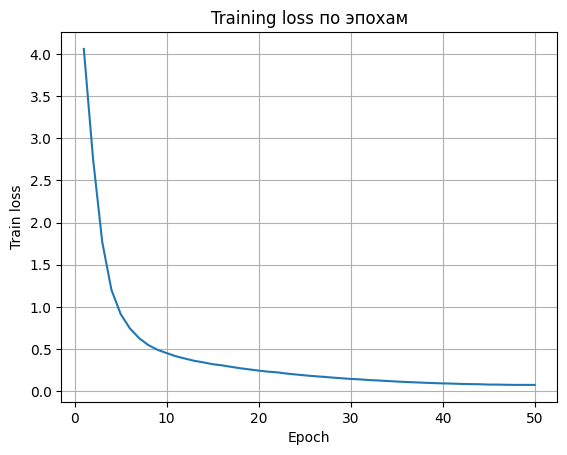

In [ ]:
plt.figure()
plt.plot(log_df["epoch"], log_df["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Training loss по эпохам")
plt.grid(True)
plt.show();

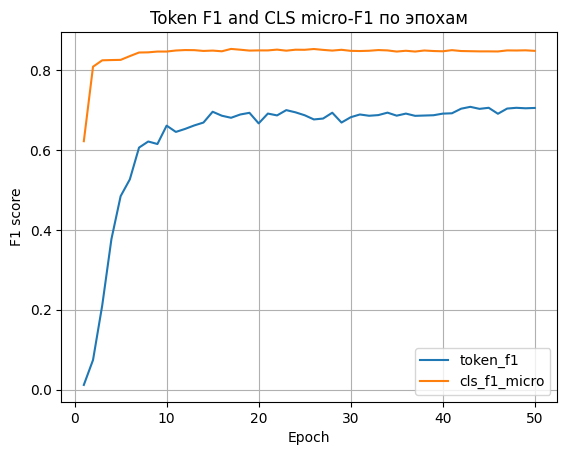

In [48]:
plt.figure()
plt.plot(log_df["epoch"], log_df["token_f1"], label="token_f1")
plt.plot(log_df["epoch"], log_df["cls_f1_micro"], label="cls_f1_micro")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Token F1 and CLS micro-F1 по эпохам")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
log_df.head()

,epoch,train_loss,token_f1,cls_f1_micro
0,1,4.059852,0.011582,0.621900
1,2,2.760002,0.074069,0.808427
2,3,1.770275,0.210722,0.824446
3,4,1.201258,0.376830,0.825104
4,5,0.914896,0.484267,0.825543


#### Кратко про метрики

**cls_micro_f1** выходит на плато уже на ранних этапах обучения и в дальнейшем практически не меняется. Это может быть связано с несколькими факторами:

1) Как мы видели в секции EDA - у нас сильный дисбаланс отношений в задаче классификации. В данных доля отрицательных меток существенно превышает долю положительных, поэтому даже относительно небольшие изменения в предсказаниях по редким классам слабо отражаются на итоговом значении

2) Задача классификации является более простой по сравнению с NER: модель достаточно быстро обучается распознавать общие признаки событий и отношений на уровне всего текста. Поэтому модель быстро достигает предела качества и дальнейшее обучение на дает роста метрики


**token_f1** до 10 эпохи растет очень быстро. После рост метрики замедляется и примерно к 15 эпохе выходит на плато с колебаниями в районе ~0.7.

## 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


In [128]:
import re
import torch
import numpy as np


import numpy as np
import torch

def pred_from_text(text, model, tokenizer, device, id2label, id2relation, topk=10, max_length=128):
    tokens = text.split()

    enc = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

    word_ids = enc.word_ids(batch_index=0)
    enc = {k: v.to(device) for k, v in enc.items()}

    model.eval()
    with torch.no_grad():
        out = model(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            token_type_ids=enc.get("token_type_ids", None),
            labels=None,
            cls_labels=None,
        )

        token_logits = out["token_logits"][0]
        pred_ids = torch.argmax(token_logits, dim=-1).detach().cpu().tolist()

        cls_logits = out["cls_logits"][0]
        cls_probs = torch.sigmoid(cls_logits).detach().cpu().numpy()

    # word-level BIO
    bio_pred = []
    seen = set()
    for tok_i, w_id in enumerate(word_ids):
        if w_id is None or w_id in seen:
            continue
        seen.add(w_id)
        bio_pred.append(id2label[int(pred_ids[tok_i])])

    L = min(len(tokens), len(bio_pred))
    tokens = tokens[:L]
    bio_pred = bio_pred[:L]

    # CLS
    pred_idx = np.where(cls_probs >= 0.5)[0]
    cls_pred_relations = sorted(
        [(id2relation[int(i)], float(cls_probs[int(i)])) for i in pred_idx],
        key=lambda x: x[1],
        reverse=True,
    )

    return {
        "text": text,
        "tokens": tokens,
        "bio_pred": bio_pred,
        "cls_probs": cls_probs,
        "cls_pred_relations": cls_pred_relations    
        }


In [129]:
id2relation = {i: r for i, r in enumerate(relations)}


In [130]:
import pandas as pd

def res_test_example(test_example, model, tokenizer, device, id2label, id2relation):
    sample_text = test_example["text"]

    pred = pred_from_text(
        text=sample_text,
        model=model,
        tokenizer=tokenizer,
        device=device,
        id2label=id2label,
        id2relation=id2relation
    )

    L = min(len(test_example["tokens"]), len(test_example["tags"]), len(pred["tokens"]), len(pred["bio_pred"]))

    pred_ner_df = pd.DataFrame({
        "token": test_example["tokens"][:L],
        "real_tag": test_example["tags"][:L],
        "pred_tag": pred["bio_pred"][:L],
    })

    pred_ner_df["is_error"] = pred_ner_df["real_tag"] != pred_ner_df["pred_tag"]


    real_rel = [id2relation[i] for i, v in enumerate(test_example["cls_vec"]) if v == 1]

    pred_rel_df = pd.DataFrame(pred["cls_pred_relations"], columns=["pred_rel", "p"])
    pred_rel_df["is_true"] = pred_rel_df["pred_rel"].map(lambda x: x in real_rel)

    pred_rel_set = set(pred_rel_df["pred_rel"].tolist())
    missed_real_rel = sorted([r for r in real_rel if r not in pred_rel_set])

    return pred_ner_df, pred_rel_df, missed_real_rel

In [198]:
for i in range(9):
    test_example = test_examples[i]
    pred_ner_df, pred_rel_df, missed_real_rel = res_test_example(
    test_example=test_example,
    model=model,
    tokenizer=tokenizer,
    device=device,
    id2label=id2label,
    id2relation=id2relation)

    print(f'-------------{i}-----------')
    print(pred_ner_df.query("is_error"))
    print()
    print("Пропущенные моделью отношения: ", missed_real_rel)
    print(pred_rel_df)
    print()

-------------0-----------
        token real_tag  pred_tag  is_error
28     "1+1",        O  B-NUMBER      True
50  прошедшем   I-DATE    B-DATE      True

Пропущенные моделью отношения:  ['AWARDED_WITH']
            pred_rel         p  is_true
0           WORKS_AS  0.994415     True
1   ALTERNATIVE_NAME  0.990729     True
2     PARTICIPANT_IN  0.982494     True
3       ORIGINS_FROM  0.966484     True
4   HEADQUARTERED_IN  0.965845     True
5             AGE_IS  0.962771     True
6          WORKPLACE  0.942748     True
7      POINT_IN_TIME  0.848768    False
8         LOCATED_IN  0.807338    False
9     TAKES_PLACE_IN  0.750262     True
10           PART_OF  0.715297    False
11             AGENT  0.507695     True

-------------1-----------
             token      real_tag        pred_tag  is_error
3               РФ  I-PROFESSION       B-COUNTRY      True
36           Архив             O  B-ORGANIZATION      True
37        Директор  B-PROFESSION  B-ORGANIZATION      True
38        св

На таком небольшом количестве примеров сложно делать какие-то устойчивые выводы, но по ручному разбору видно несколько повторяющихся типов ошибок.

- В NER модель чаще всего путает близкие по смыслу теги: в первую очередь TIME и DATE, а также PROFESSION и ORGANIZATION. 
- Довольно много ошибок связано с границами сущностей: смешение B и I тегов, частичные захваты многословных сущностей. Также встречаются ложные срабатывания на O токенах, когда модель достраивает сущность там, где её нет.

- По отношениям видно, что модель лучше всего справляется с базовыми и часто встречающимися связями (WORKPLACE, WORKS_AS, PARTICIPANT_IN, TAKES_PLACE_IN, POINT_IN_TIME). При этом более редкие или контекстно сложные отношения часто пропускаются. 

В целом ручной анализ позволяет понять характер ошибок, но не даёт возможности количественно оценить, какие теги и отношения являются самыми проблемными. Поэтому дальше имеет смысл сделать агрегированную статистику по всему тестовому датасету, чтобы подтвердить эти наблюдения и точнее определить слабые места модели.

Соберем статистику по всем тэгам и отношениям в тестовом датасете

In [181]:
ner_rows = []          
rel_counts = {}        
rel_conf_rows = []    

for example_id, ex in enumerate(test_examples):
    pred_ner_df, pred_rel_df, _ = res_test_example(
        test_example=ex,
        model=model,
        tokenizer=tokenizer,
        device=device,
        id2label=id2label,
        id2relation=id2relation
    )

    # NER: сохраняем пары (real_tag, pred_tag)
    ner_part = pred_ner_df[["token", "real_tag", "pred_tag"]].copy()
    ner_part["example_id"] = example_id
    ner_rows.append(ner_part)

    # Relations: реальные и предсказанные отношения
    real_rel = {
        id2relation[i]
        for i, v in enumerate(ex["cls_vec"])
        if v == 1
    }
    pred_rel = set(pred_rel_df["pred_rel"].tolist())

    # Обновляем счётчики TP/FP/FN
    all_relations_in_example = real_rel | pred_rel
    for rel in all_relations_in_example:
        if rel not in rel_counts:
            rel_counts[rel] = {"tp": 0, "fp": 0, "fn": 0}

        is_pred = rel in pred_rel
        is_real = rel in real_rel

        if is_pred and is_real:
            rel_counts[rel]["tp"] += 1
        elif is_pred and not is_real:
            rel_counts[rel]["fp"] += 1
        elif (not is_pred) and is_real:
            rel_counts[rel]["fn"] += 1

In [164]:
pairs_df = pd.concat(ner_rows, ignore_index=True)

labels = sorted(set(pairs_df["real_tag"]).union(set(pairs_df["pred_tag"])))

cm = (
    pd.crosstab(pairs_df["real_tag"], pairs_df["pred_tag"])
      .reindex(index=labels, columns=labels, fill_value=0)
)

In [176]:
# из cm соберем статистику по полноте и наиболее частым путаницам в тэгах

def ner_recall_and_top_confusions(cm, top_k=3):

    rows = []
    labels = list(cm.index)

    for real_tag in labels:
        row = cm.loc[real_tag]

        cnt_real = int(row.sum())
        tp = int(row.get(real_tag, 0))
        recall = tp / cnt_real if cnt_real > 0 else np.nan

        err = row.copy()
        if real_tag in err.index:
            err.loc[real_tag] = 0

        top = err.sort_values(ascending=False).head(top_k)

        out = {
            "real_tag": real_tag,
            "cnt_real": cnt_real,
            "tp": tp,
            "recall": recall,
        }

        for k in range(1, top_k + 1):
            if k <= len(top):
                conf_tag = top.index[k - 1]
                conf_cnt = int(top.iloc[k - 1])
                out[f"top_{k}_conf_tag"] = conf_tag if conf_cnt > 0 else np.nan
                out[f"top_{k}_conf_cnt"] = conf_cnt if conf_cnt > 0 else 0
            else:
                out[f"top_{k}_conf_tag"] = np.nan
                out[f"top_{k}_conf_cnt"] = 0

        rows.append(out)

    res = pd.DataFrame(rows)
    return res.sort_values("cnt_real", ascending=False).reset_index(drop=True)


In [199]:
ner_summary = ner_recall_and_top_confusions(cm, top_k=3)
ner_summary.head(15)

,real_tag,cnt_real,tp,recall,top_1_conf_tag,top_1_conf_cnt,top_2_conf_tag,top_2_conf_cnt,top_3_conf_tag,top_3_conf_cnt
0,O,2475,2264,0.914747,B-EVENT,58,I-EVENT,32,B-PROFESSION,21
1,B-PERSON,329,322,0.978723,B-ORGANIZATION,2,B-PRODUCT,2,B-WORK_OF_ART,1
2,I-DATE,320,316,0.987500,B-DATE,3,O,1,NaN,0
3,I-PERSON,295,288,0.976271,I-ORGANIZATION,3,B-PERSON,1,I-AWARD,1
4,B-EVENT,272,217,0.797794,O,34,I-EVENT,13,B-ORGANIZATION,5
5,B-PROFESSION,242,198,0.818182,O,13,B-COUNTRY,7,I-PROFESSION,5
6,B-DATE,144,130,0.902778,I-DATE,10,O,3,B-EVENT,1
7,I-EVENT,144,96,0.666667,O,25,B-EVENT,8,I-ORGANIZATION,6
8,B-ORGANIZATION,141,107,0.758865,I-ORGANIZATION,8,I-PROFESSION,5,O,5
9,B-COUNTRY,122,106,0.868852,B-NATIONALITY,10,I-ORGANIZATION,3,O,1


In [ ]:
rel_rows = []
for rel, c in rel_counts.items():
    tp, fp, fn = c["tp"], c["fp"], c["fn"]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    rel_rows.append({
        "relation": rel,
        "tp": tp, "fp": fp, "fn": fn,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

rel_metrics = pd.DataFrame(rel_rows).sort_values(["f1", "tp"], ascending=[False, False])

In [202]:
rel_metrics.head(30)

,relation,tp,fp,fn,precision,recall,f1
9,ALTERNATIVE_NAME,87,6,0,0.935484,1.000000,0.966667
8,PARTICIPANT_IN,84,7,1,0.923077,0.988235,0.954545
10,WORKS_AS,80,12,1,0.869565,0.987654,0.924855
5,POINT_IN_TIME,73,14,4,0.839080,0.948052,0.890244
7,TAKES_PLACE_IN,64,12,7,0.842105,0.901408,0.870748
1,AGE_IS,61,14,5,0.813333,0.924242,0.865248
18,AGE_DIED_AT,13,4,1,0.764706,0.928571,0.838710
2,WORKPLACE,62,20,6,0.756098,0.911765,0.826667
6,HEADQUARTERED_IN,51,15,11,0.772727,0.822581,0.796875
11,ORIGINS_FROM,50,14,13,0.781250,0.793651,0.787402


После агрегации по всему тестовому датасету картина становится яснее.

По NER в целом модель работает стабильно: у большинства частотных тегов recall выше 0.85–0.9. Лучше всего распознаются PERSON, DATE, AGE — там ошибки единичные и в основном связаны с границами сущностей. При этом явно проблемными остаются I-теги, особенно I-PROFESSION и I-EVENT: у них самый низкий recall, и чаще всего они путаются либо с O, либо с организационными тегами. Это подтверждает наблюдение из ручного анализа.

Отдельно видно, что для B-EVENT и I-EVENT модель регулярно либо пропускает сущность, либо путает B и I между собой, что указывает на слабое обучение именно событийных сущностей. Также сохраняется путаница между PROFESSION и ORGANIZATION, особенно на внутренних токенах.

По классификации отношений распределение качества сильно неравномерное. Небольшое число базовых отношений (ALTERNATIVE_NAME, PARTICIPANT_IN, WORKS_AS, POINT_IN_TIME, TAKES_PLACE_IN) имеют высокий recall и хороший f1, модель уверенно их находит и редко пропускает. 

Дальше видно резкое падение качества: у значительной части отношений recall ниже 0.5, а у некоторых он практически нулевой. Это в основном редкие отношения.

В итоге агрегированная статистика подтверждает выводы из ручного анализа: модель уверенно покрывает основные, частотные сценарии, но теряет качество на длинных сущностях, I-тегах и редких отношениях. Это указывает на основные направления для улучшения: усиление обучения границ сущностей и балансировка/дообучение редких relations.

In [78]:
res["cls_top"]

[('WORKS_AS', 0.9944149255752563),
 ('ALTERNATIVE_NAME', 0.9907293915748596),
 ('PARTICIPANT_IN', 0.982494056224823),
 ('ORIGINS_FROM', 0.9664835929870605),
 ('HEADQUARTERED_IN', 0.9658454060554504),
 ('AGE_IS', 0.9627705216407776),
 ('WORKPLACE', 0.942747950553894),
 ('POINT_IN_TIME', 0.8487682342529297)]

In [75]:
print("TOP relations:", res["cls_top"][:5])
for tok, tag in zip(res["tokens"], res["bio_pred"]):
    if tag != "O":
        print(f"{tok:20s} {tag}")

TOP relations: [('WORKS_AS', 0.9944149255752563), ('ALTERNATIVE_NAME', 0.9907293915748596), ('PARTICIPANT_IN', 0.982494056224823), ('ORIGINS_FROM', 0.9664835929870605), ('HEADQUARTERED_IN', 0.9658454060554504)]
Словацкий            B-NATIONALITY
тренер               B-PROFESSION
Жолт                 B-PERSON
Хорняк               I-PERSON
возглавил            B-EVENT
"Бананц"             B-ORGANIZATION
(Ереван)             B-CITY
Словацкий            B-NATIONALITY
тренер               B-PROFESSION
Жолт                 B-PERSON
Хорняк               I-PERSON
главным              B-PROFESSION
тренером             I-PROFESSION
футбольного          I-PROFESSION
клуба                I-PROFESSION
"Бананц"             I-PROFESSION
(Ереван).            B-CITY
40                   B-AGE
летним               I-AGE
тренером             B-PROFESSION
"1+1",               B-NUMBER
главного             B-PROFESSION
тренера              I-PROFESSION
"Бананца"            B-ORGANIZATION
Хорняк            

In [54]:
tokens = test_example["tokens"]
true_tags = test_example["tags"]

len(tokens), len(true_tags)

(62, 62)

In [61]:
w_col = max(len(t) for t in tokens)
t_col = max(len(t) for t in true_tags)
p_col = max(len(t) for t in pred_tags)

header = f"{'token':{w_col}}  {'true':{t_col}}  {'pred':{p_col}}  flag"
print(header)
print("-" * len(header))

for tok, t, p in zip(tokens, true_tags, pred_tags):
    flag = "!" if t != p else ""
    print(f"{tok:{w_col}}  {t:{t_col}}  {p:{p_col}}  {flag}")

token         true            pred            flag
--------------------------------------------------
Словацкий     B-NATIONALITY   B-NATIONALITY   
тренер        B-PROFESSION    B-PROFESSION    
Жолт          B-PERSON        B-PERSON        
Хорняк        I-PERSON        I-PERSON        
возглавил     B-EVENT         B-EVENT         
"Бананц"      B-ORGANIZATION  B-ORGANIZATION  
(Ереван)      B-CITY          B-CITY          
Словацкий     B-NATIONALITY   B-NATIONALITY   
тренер        B-PROFESSION    B-PROFESSION    
Жолт          B-PERSON        B-PERSON        
Хорняк        I-PERSON        I-PERSON        
стал          O               O               
новым         O               O               
главным       B-PROFESSION    B-PROFESSION    
тренером      I-PROFESSION    I-PROFESSION    
футбольного   I-PROFESSION    I-PROFESSION    
клуба         I-PROFESSION    I-PROFESSION    
"Бананц"      I-PROFESSION    I-PROFESSION    
(Ереван).     B-CITY          B-CITY          
Контр

##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!